# Robot Class

In this project, we'll be localizing a robot in a 2D grid world. The basis for simultaneous localization and mapping (SLAM) is to gather information from a robot's sensors and motions over time, and then use information about measurements and motion to re-construct a map of the world.

### Uncertainty

As you've learned, robot motion and sensors have some uncertainty associated with them. For example, imagine a car driving up hill and down hill; the speedometer reading will likely overestimate the speed of the car going up hill and underestimate the speed of the car going down hill because it cannot perfectly account for gravity. Similarly, we cannot perfectly predict the *motion* of a robot. A robot is likely to slightly overshoot or undershoot a target location.

In this notebook, we'll look at the `robot` class that is *partially* given to you for the upcoming SLAM notebook. First, we'll create a robot and move it around a 2D grid world. Then, **you'll be tasked with defining a `sense` function for this robot that allows it to sense landmarks in a given world**! It's important that you understand how this robot moves, senses, and how it keeps track of different landmarks that it sees in a 2D grid world, so that you can work with it's movement and sensor data.

---

Before we start analyzing robot motion, let's load in our resources and define the `robot` class. You can see that this class initializes the robot's position and adds measures of uncertainty for motion. You'll also see a `sense()` function which is not yet implemented, and you will learn more about that later in this notebook.

# 로봇 클래스

이 프로젝트에서는 2D 격자 세계에서 로봇의 위치를 ​​파악합니다. 동시 위치 측정 및 매핑(SLAM)의 기본 원리는 시간 경과에 따라 로봇의 센서와 동작 정보를 수집한 다음, 측정값과 동작 정보를 사용하여 세계 지도를 재구성하는 것입니다.

### 불확실성

앞서 학습했듯이 로봇의 동작과 센서에는 불확실성이 존재합니다. 예를 들어, 오르막길과 내리막길을 달리는 자동차를 상상해 보세요. 속도계는 중력을 완벽하게 고려할 수 없기 때문에 오르막길에서는 자동차의 속도를 과대평가하고 내리막길에서는 자동차의 속도를 과소평가할 가능성이 높습니다. 마찬가지로, 로봇의 *동작*도 완벽하게 예측할 수 없습니다. 로봇은 목표 위치를 약간 초과하거나 미달할 가능성이 높습니다.

이 노트북에서는 앞으로 진행될 SLAM 노트북에서 *부분적으로* 제공되는 `robot` 클래스를 살펴보겠습니다. 먼저 로봇을 생성하고 2D 격자 세계에서 이동시켜 보겠습니다. 그런 다음, **주어진 세계에서 랜드마크를 감지할 수 있도록 이 로봇에 대한 `sense` 함수를 정의해야 합니다**! 이 로봇이 어떻게 움직이고, 감지하고, 2D 그리드 세계에서 보이는 다양한 랜드마크를 어떻게 추적하는지 이해하는 것이 중요합니다. 그래야 로봇의 움직임과 센서 데이터를 활용할 수 있습니다.

---

로봇 동작 분석을 시작하기 전에 리소스를 로드하고 `robot` 클래스를 정의해 보겠습니다. 이 클래스는 로봇의 위치를 ​​초기화하고 동작의 불확실성을 측정하는 기능을 추가합니다. 또한 아직 구현되지 않은 `sense()` 함수도 있는데, 이 노트의 뒷부분에서 자세히 살펴보겠습니다.

In [2]:
%pip install matplotlib

  Using cached matplotlib-3.10.1-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.8-cp312-cp312-win_amd64.whl.metadata (6.3 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.1-cp312-cp312-win_amd64.whl (8.1 MB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 2.2/2.2 MB 20.6 MB/s eta 0:00:00
Using cached kiwisolver-1.4.8-cp312-cp312-win_amd64.whl (71 kB)
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 2.7/2.7 MB 38.3 MB/s eta 0:00:00
Using cached pyparsing-3.2.3-py3-none-any.whl (111 kB)
Note: you may need to restart the kernel to use updated packages.


In [14]:
# import some resources
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [36]:
# the robot class
class robot:

    # --------
    # init:
    #   creates a robot with the specified parameters and initializes
    #   the location (self.x, self.y) to the center of the world
    #
    def __init__(self, world_size = 100.0, measurement_range = 30.0,
                 motion_noise = 1.0, measurement_noise = 1.0):
        self.measurement_noise = 0.0
        self.world_size = world_size
        self.measurement_range = measurement_range
        self.x = world_size / 2.0
        self.y = world_size / 2.0
        self.motion_noise = motion_noise
        self.measurement_noise = measurement_noise
        self.landmarks = []
        self.num_landmarks = 0


    # returns a positive, random float
    def rand(self):
        return random.random() * 2.0 - 1.0


    # --------
    # move: attempts to move robot by dx, dy. If outside world
    #       boundary, then the move does nothing and instead returns failure
    #
    def move(self, dx, dy):

        x = self.x + dx + self.rand() * self.motion_noise
        y = self.y + dy + self.rand() * self.motion_noise

        if x < 0.0 or x > self.world_size or y < 0.0 or y > self.world_size:
            return False
        else:
            self.x = x
            self.y = y
            return True


    # --------
    # sense: returns x- and y- distances to landmarks within visibility range
    #        because not all landmarks may be in this range, the list of measurements
    #        is of variable length. Set measurement_range to -1 if you want all
    #        landmarks to be visible at all times
    #

    ## TODO: complete the sense function
    def sense(self):
        ''' This function does not take in any parameters, instead it references internal variables
            (such as self.landmarks) to measure the distance between the robot and any landmarks
            that the robot can see (that are within its measurement range).
            This function returns a list of landmark indices, and the measured distances (dx, dy)
            between the robot's position and said landmarks.
            This function should account for measurement_noise and measurement_range.
            One item in the returned list should be in the form: [landmark_index, dx, dy].
            '''

        measurements = []

        ## TODO: iterate through all of the landmarks in a world

        for i in range(len(self.landmarks)):
            #landmark_id = i
            dx = self.landmarks[i][0] - self.x + self.rand() * self.measurement_noise
            dy = self.landmarks[i][1] - self.y + self.rand() * self.measurement_noise

            if self.measurement_range == -1 or (abs(dx) <= self.measurement_range and abs(dy) <= self.measurement_range):
                measurements.append([i, dx, dy])


        ## TODO: return the final, complete list of measurements
        return measurements


    # --------
    # make_landmarks:
    # make random landmarks located in the world
    #
    def make_landmarks(self, num_landmarks):
        self.landmarks = []
        for i in range(num_landmarks):
            self.landmarks.append([round(random.random() * self.world_size),
                                   round(random.random() * self.world_size)])
        self.num_landmarks = num_landmarks


    # called when print(robot) is called; prints the robot's location
    def __repr__(self):
        return 'Robot: [x=%.5f y=%.5f]'  % (self.x, self.y)


## Define a world and a robot

Next, let's instantiate a robot object. As you can see in `__init__` above, the robot class takes in a number of parameters including a world size and some values that indicate the sensing and movement capabilities of the robot.

In the next example, we define a small 10x10 square world, a measurement range that is half that of the world and small values for motion and measurement noise. These values will typically be about 10 times larger, but we ust want to demonstrate this behavior on a small scale. You are also free to change these values and note what happens as your robot moves!

## 월드와 로봇 정의

다음으로, 로봇 객체를 인스턴스화해 보겠습니다. 위의 `__init__`에서 볼 수 있듯이, 로봇 클래스는 월드 크기와 로봇의 감지 및 이동 능력을 나타내는 몇 가지 값을 포함한 여러 매개변수를 받습니다.

다음 예제에서는 10x10 크기의 작은 월드, 월드의 절반에 해당하는 측정 범위, 그리고 동작 및 측정 노이즈에 대한 작은 값을 정의합니다. 이러한 값은 일반적으로 약 10배 더 크지만, 여기서는 작은 규모에서 이러한 동작을 보여드리고자 합니다. 이 값들을 자유롭게 변경하고 로봇이 움직일 때 어떤 일이 일어나는지 확인해 보세요!

In [37]:
world_size         = 10.0    # size of world (square)
measurement_range  = 5.0     # range at which we can sense landmarks
motion_noise       = 0.2      # noise in robot motion
measurement_noise  = 0.2      # noise in the measurements

# instantiate a robot, r
r = robot(world_size, measurement_range, motion_noise, measurement_noise)

# print out the location of r
print(r)

Robot: [x=5.00000 y=5.00000]


## Visualizing the World

In the given example, we can see/print out that the robot is in the middle of the 10x10 world at (x, y) = (5.0, 5.0), which is exactly what we expect!

However, it's kind of hard to imagine this robot in the center of a world, without visualizing the grid itself, and so in the next cell we provide a helper visualization function, `display_world`, that will display a grid world in a plot and draw a red `o` at the location of our robot, `r`. The details of how this function works can be found in the `helpers.py` file in the home directory; you do not have to change anything in this `helpers.py` file.

## 세상 시각화

주어진 예제에서 로봇이 10x10 세상의 중앙에 (x, y) = (5.0, 5.0) 위치에 있음을 확인/출력할 수 있습니다. 이는 예상했던 결과입니다!

하지만 그리드 자체를 시각화하지 않고는 이 로봇이 세상의 중심에 있다고 상상하기 어렵습니다. 따라서 다음 셀에 `display_world`라는 보조 시각화 함수를 제공합니다. 이 함수는 플롯에 그리드 세상을 표시하고 로봇의 위치인 `r`에 빨간색 `o`를 그립니다. 이 함수의 작동 방식에 대한 자세한 내용은 홈 디렉터리의 `helpers.py` 파일에서 확인할 수 있습니다. 이 `helpers.py` 파일에서는 아무것도 변경할 필요가 없습니다.

In [38]:
%pip install seaborn


Note: you may need to restart the kernel to use updated packages.


Robot: [x=5.00000 y=5.00000]


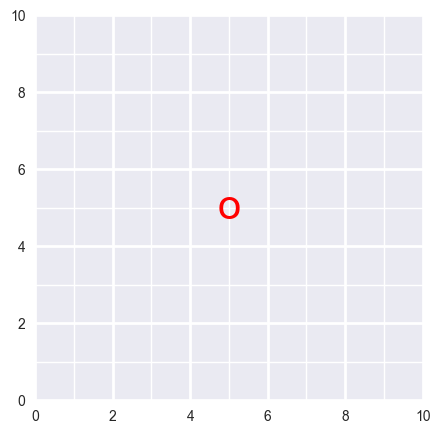

In [39]:
# import helper function
from helpers import display_world

# define figure size
plt.rcParams["figure.figsize"] = (5,5)

# call display_world and display the robot in it's grid world
print(r)
display_world(int(world_size), [r.x, r.y])

## Movement

Now you can really picture where the robot is in the world! Next, let's call the robot's `move` function. We'll ask it to move some distance `(dx, dy)` and we'll see that this motion is not perfect by the placement of our robot `o` and by the printed out position of `r`. 

Try changing the values of `dx` and `dy` and/or running this cell multiple times; see how the robot moves and how the uncertainty in robot motion accumulates over multiple movements.

#### For a `dx` = 1, does the robot move *exactly* one spot to the right? What about `dx` = -1? What happens if you try to move the robot past the boundaries of the world?

## 이동

이제 로봇이 실제 세상에서 어디에 있는지 정확히 알 수 있습니다! 다음으로, 로봇의 `move` 함수를 호출해 보겠습니다. 로봇에게 `(dx, dy)`만큼 이동하도록 요청하면, 로봇의 위치 `o`와 출력된 `r`의 위치를 ​​통해 이 동작이 완벽하지 않다는 것을 확인할 수 있습니다.

`dx`와 `dy` 값을 변경하거나 이 셀을 여러 번 실행해 보세요. 로봇이 어떻게 움직이는지, 그리고 로봇 동작의 불확실성이 여러 번 이동하면서 어떻게 누적되는지 살펴보세요.

#### `dx` = 1일 때, 로봇은 *정확히* 오른쪽으로 한 지점 이동할까요? `dx` = -1일 때는 어떨까요? 로봇을 실제 세상의 경계를 넘어 이동시키려고 하면 어떻게 될까요?

Robot: [x=5.87367 y=6.82267]


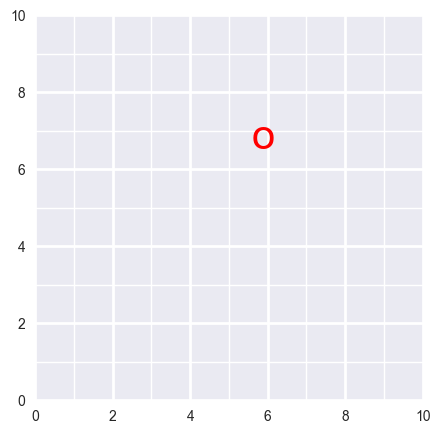

In [40]:
# choose values of dx and dy (negative works, too)
dx = 1
dy = 2
r.move(dx, dy)

# print out the exact location
print(r)

# display the world after movement, not that this is the same call as before
# the robot tracks its own movement
display_world(int(world_size), [r.x, r.y])

## Landmarks

Next, let's create landmarks, which are measurable features in the map. You can think of landmarks as things like notable buildings, or something smaller such as a tree, rock, or other feature.

The robot class has a function `make_landmarks` which randomly generates locations for the number of specified landmarks. Try changing `num_landmarks` or running this cell multiple times to see where these landmarks appear. We have to pass these locations as a third argument to the `display_world` function and the list of landmark locations is accessed similar to how we find the robot position `r.landmarks`.

Each landmark is displayed as a purple `x` in the grid world, and we also print out the exact `[x, y]` locations of these landmarks at the end of this cell.


## 랜드마크

다음으로, 지도에서 측정 가능한 특징인 랜드마크를 만들어 보겠습니다. 랜드마크는 눈에 띄는 건물이나 나무, 바위 또는 기타 특징과 같은 작은 물체로 생각할 수 있습니다.

로봇 클래스에는 지정된 랜드마크 개수만큼 위치를 무작위로 생성하는 `make_landmarks` 함수가 있습니다. `num_landmarks`를 변경하거나 이 셀을 여러 번 실행하여 랜드마크가 어디에 나타나는지 확인해 보세요. 이 위치들을 `display_world` 함수의 세 번째 인수로 전달해야 하며, 로봇 위치 `r.landmarks`를 찾는 방식과 유사하게 랜드마크 위치 목록에 접근합니다.

각 랜드마크는 그리드 월드에 보라색 `x`로 표시되며, 이 셀의 끝에는 랜드마크의 정확한 `[x, y]` 위치도 출력합니다.

Robot: [x=5.87367 y=6.82267]


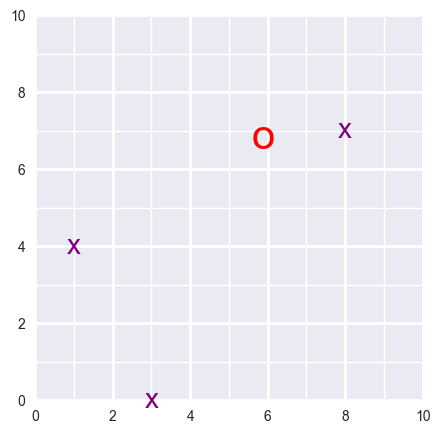

Landmark locations [x,y]:  [[3, 0], [1, 4], [8, 7]]


In [41]:
# create any number of landmarks
num_landmarks = 3
r.make_landmarks(num_landmarks)

# print out our robot's exact location
print(r)

# display the world including these landmarks
display_world(int(world_size), [r.x, r.y], r.landmarks)

# print the locations of the landmarks
print('Landmark locations [x,y]: ', r.landmarks)

## Sense

Once we have some landmarks to sense, we need to be able to tell our robot to *try* to sense how far they are away from it. It will be up t you to code the `sense` function in our robot class.

The `sense` function uses only internal class parameters and returns a list of the the measured/sensed x and y distances to the landmarks it senses within the specified `measurement_range`. 

### TODO: Implement the `sense` function 

Follow the `##TODO's` in the class code above to complete the `sense` function for the robot class. Once you have tested out your code, please **copy your complete `sense` code to the `robot_class.py` file in the home directory**. By placing this complete code in the `robot_class` Python file, we will be able to refernce this class in a later notebook.

The measurements have the format, `[i, dx, dy]` where `i` is the landmark index (0, 1, 2, ...) and `dx` and `dy` are the measured distance between the robot's location (x, y) and the landmark's location (x, y). This distance will not be perfect since our sense function has some associated `measurement noise`.

---

In the example in the following cell, we have a given our robot a range of `5.0` so any landmarks that are within that range of our robot's location, should appear in a list of measurements. Not all landmarks are guaranteed to be in our visibility range, so this list will be variable in length.

*Note: the robot's location is often called the **pose** or `[Pxi, Pyi]` and the landmark locations are often written as `[Lxi, Lyi]`. You'll see this notation in the next notebook.*

## 감지

감지할 랜드마크가 생기면 로봇에게 랜드마크와의 거리를 감지하도록 *시도*해야 합니다. 로봇 클래스에서 `sense` 함수를 코딩해야 합니다.

`sense` 함수는 내부 클래스 매개변수만 사용하고, 지정된 `measurement_range` 내에서 감지한 랜드마크까지의 측정/감지된 x 및 y 거리 목록을 반환합니다.

### TODO: `sense` 함수 구현하기

위 클래스 코드의 `##TODO`를 따라 로봇 클래스의 `sense` 함수를 완성하세요. 코드를 테스트한 후 **전체 `sense` 코드를 홈 디렉터리의 `robot_class.py` 파일에 복사하세요**. 이 전체 코드를 `robot_class` Python 파일에 넣으면 나중에 이 클래스를 참조할 수 있습니다.

측정값은 `[i, dx, dy]` 형식을 갖습니다. 여기서 `i`는 랜드마크 인덱스(0, 1, 2, ...)이고, `dx`와 `dy`는 로봇의 위치(x, y)와 랜드마크의 위치(x, y) 사이의 측정 거리입니다. 감지 함수에 관련된 `측정 노이즈`가 있으므로 이 거리는 완벽하지 않습니다.

---

다음 셀의 예시에서 로봇의 범위를 `5.0`으로 지정했으므로 로봇 위치의 해당 범위 내에 있는 모든 랜드마크는 측정값 목록에 나타나야 합니다. 모든 랜드마크가 가시 범위 내에 있다고 보장되는 것은 아니므로 이 목록의 길이는 가변적입니다.

*참고: 로봇의 위치는 종종 **포즈** 또는 `[Pxi, Pyi]`라고 하며, 랜드마크 위치는 종종 `[Lxi, Lyi]`로 표기됩니다. 이 표기법은 다음 노트에서 확인할 수 있습니다.*

In [42]:
# try to sense any surrounding landmarks
measurements = r.sense()

# this will print out an empty list if `sense` has not been implemented
print(measurements)

[[1, -4.68363290738684, -2.7911720991644535], [2, 2.10702038791098, 0.10345049885268857]]


**Refer back to the grid map above. Do these measurements make sense to you? Are all the landmarks captured in this list (why/why not)?**

**위의 격자 지도를 다시 참조하세요. 이 측정값이 이해가 되나요? 이 목록에 있는 모든 랜드마크가 포함되어 있나요? (그 이유는 무엇인가요?)**

---
## Data

#### Putting it all together

To perform SLAM, we'll collect a series of robot sensor measurements and motions, in that order, over a defined period of time. Then we'll use only this data to re-construct the map of the world with the robot and landmar locations. You can think of SLAM as peforming what we've done in this notebook, only backwards. Instead of defining a world and robot and creating movement and sensor data, it will be up to you to use movement and sensor measurements to reconstruct the world!

In the next notebook, you'll see this list of movements and measurements (which you'll use to re-construct the world) listed in a structure called `data`. This is an array that holds sensor measurements and movements in a specific order, which will be useful to call upon when you have to extract this data and form constraint matrices and vectors.

`data` is constructed over a series of time steps as follows:

---
## 데이터

#### 모두 합치기

SLAM을 수행하려면 정해진 기간 동안 일련의 로봇 센서 측정값과 동작을 순서대로 수집합니다. 그런 다음 이 데이터만 사용하여 로봇과 육지의 위치를 ​​포함하는 세계 지도를 재구성합니다. SLAM은 이 노트북에서 수행한 작업을 거꾸로 수행하는 것으로 생각하면 됩니다. 세계와 로봇을 정의하고 동작 및 센서 데이터를 생성하는 대신, 동작 및 센서 측정값을 사용하여 세계를 재구성하는 것은 여러분의 몫입니다!

다음 노트북에서는 세계를 재구성하는 데 사용할 동작 및 측정값 목록을 `data`라는 구조체에 나열합니다. 이 배열은 센서 측정값과 동작을 특정 순서대로 저장하는 배열로, 이 데이터를 추출하고 제약 행렬과 벡터를 형성해야 할 때 유용하게 사용할 수 있습니다.

`data`는 다음과 같이 일련의 시간 단계에 걸쳐 구성됩니다.

In [45]:
data = []

# after a robot first senses, then moves (one time step)
# that data is appended like so:
data.append([measurements, [dx, dy]])

# for our example movement and measurement
print(data)

[[[[1, -4.68363290738684, -2.7911720991644535], [2, 2.10702038791098, 0.10345049885268857]], [1, 2]]]


In [46]:
# in this example, we have only created one time step (0)
time_step = 0

# so you can access robot measurements:
print('Measurements: ', data[time_step][0])

# and its motion for a given time step:
print('Motion: ', data[time_step][1])

Measurements:  [[1, -4.68363290738684, -2.7911720991644535], [2, 2.10702038791098, 0.10345049885268857]]
Motion:  [1, 2]


### Final robot class

Before moving on to the last notebook in this series, please make sure that you have copied your final, completed `sense` function into the `robot_class.py` file in the home directory. We will be using this file in the final implementation of slam!

### 최종 로봇 수업

이 시리즈의 마지막 노트북으로 넘어가기 전에, 최종 완성된 `sense` 함수를 홈 디렉터리의 `robot_class.py` 파일에 복사했는지 확인하세요. slam의 최종 구현에 이 파일을 사용할 예정입니다!